**The objective of this project is to analyze natural gas well production data to identify promising zones, forecast production for the next 5 years in said zones, and recommend strategies for maximizing efficiency and output.**

In [1]:
#Importing libaries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
import chardet
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
drive.mount('/content/drive')

file_url = "https://open.canada.ca/data/en/dataset/26cadec4-d316-4022-97fb-8e49dd768b6d/resource/41d3afe7-eb3a-4bfe-857f-c59237f5f6f2/download/marketable-natural-gas-production-by-case.csv"

try:
    NG_wells_prod = pd.read_csv(file_url)
    print("Data successfully loaded!")
    print(data.head())  # Preview the data
except Exception as e:
    print(f"Error loading data: {e}")

#NG_wells_prod = pd.read_csv('marketable-natural-gas-production-history.csv')
print(NG_wells_prod.head())
print(NG_wells_prod.info())
print(NG_wells_prod.describe())

Mounted at /content/drive
Data successfully loaded!
Error loading data: name 'data' is not defined
      Case Province  Gas Area Type  Sub-Type      Date      Value
0  History       AB         0  CBM  Main HSC  1/1/1998  36.690785
1  History       AB         0  CBM  Main HSC  2/1/1998  37.677433
2  History       AB         0  CBM  Main HSC  3/1/1998  37.182776
3  History       AB         0  CBM  Main HSC  4/1/1998  38.407215
4  History       AB         0  CBM  Main HSC  5/1/1998  36.255105
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29052 entries, 0 to 29051
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Case      3132 non-null   object 
 1   Province  29052 non-null  object 
 2   Gas Area  29052 non-null  int64  
 3   Type      29052 non-null  object 
 4   Sub-Type  29052 non-null  object 
 5   Date      29052 non-null  object 
 6   Value     29052 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory

The data has the following description:

**Province**: Canada Province where the well is located
*   BC: Province of British Columbia
*   SK: Province of Saskatchewan
*   AB: Province of Alberta
*   MB: Province of Manitoba
*   ON: Province of Ontario
*   QU: Province of Quebec
*   NB: Province of Province of New Brunswick
*   NS: Province of Nova Scotia
*   NF: Province of Newfoundland and Labrador
*   NWT: Northwest Territories
*   YK: Yukon
*   NT: Nothern Canada (YK, NWT, YK)


**Gas Area**: Geographical zone
*   1: Geographical zone corresponding to Petrocube Area 1 called Southern Alberta representing southeastern Alberta.
*   2: Geographical zone corresponding to Petrocube Area 2 called Southern Alberta representing south-central Alberta.
*   3: Geographical zone corresponding to Petrocube Area 3 called Southern Foothills representing southwestern Alberta.
*   4: Geographical zone corresponding to Petrocube Area 4 called Eastern Alberta representing east-central Alberta.
*   5: Geographical zone corresponding to Petrocube Area 5 called Central Alberta representing cetnral Alberta.
*   6: Geographical zone corresponding to Petrocube Area 6 called West Central Alberta representing the south-eastern part of the Foothills in central Alberta.
*   7: Geographical zone corresponding to Petrocube Area 7 called Central Foothills representing west-central Alberta.  
*   8: Geographical zone corresponding to Petrocube Area 8 called Kaybob representing central Alberta.  
*   9: Geographical zone corresponding to Petrocube Area 9 called Alberta Deep Basin representing the northern part of the Foothills in west-cetnral Alberta.
*   10: Geographical zone corresponding to Petrocube Area 10 called Northeast Alberta representing northeastern Alberta.
*   11: Geographical zone corresponding to Petrocube Area 11 called Peace River representing northwestern Alberta.
*   12: Geographical zone corresponding to Petrocube Area 12 called Northwest Alberta representing northwestern Alberta.
*   13: Geographical zone corresponding to Petrocube Area 13 called BC Deep Basin representing the northern part of the Foothills in British Columbia.
*   14: Geographical zone corresponding to Petrocube Area 14 called Fort St John representing northwestern British Columbia.
*   15: Geographical zone corresponding to Petrocube Area 15 called Northeast BC representing northeastern British Columbia.
*   16: Geographical zone corresponding to Petrocube Area 16 called BC Foothills representing northeastern BC.
*   17: Geographical zone corresponding to Petrocube Area 17 called Southwest Saskatchewan representing southwestern Saskatchewan.
*   18: Geographical zone corresponding to Petrocube Area 18 called West Saskatchewan representing western Saskatchewan.
*   19: Geographical zone corresponding to Petrocube Area 19 called East Saskatchewan representing eastern Saskatchewan.
*   20: Geographical zone corresponding to Area 20 representing the province of New Brunswick.
*   21: Geographical zone corresponding to Area 21 representing the province of Nova Scotia (onshore and offshore).
*   22: Geographical zone corresponding to Area 22 representing northern Canada (NT).
*   23: Geographical zone corresponding to Area 23 representing the province of Ontario.
*   24: Geographical zone corresponding to Area 24 representing the province of Quebec.
*   25: Geographical zone corresponding to Area 25 representing the province of Manitoba.
*   26: Geographical zone corresponding to Area 26 representing the province of Newfoundland and Labrador (onshroe and offshore).

**Type**: Type of resource

*   Conventional: Conventional gas resource (not including tight).  See http://www.neb-one.gc.ca/nrg/tl/glssr-eng.html for complete Glossary of terms
*   Tight: Tight resource (is still considered "conventional"). Montney is tight gas, since it is composed of siltstone and sandstone, not shale.  See http://www.neb-one.gc.ca/nrg/tl/glssr-eng.html for complete Glossary of terms
*   Shale: Shale resource (Shale resource plays are Horn River, Liard, Cordova and Duvernay)
*   CBM: Coalbed Methane resource.  See http://www.neb-one.gc.ca/nrg/tl/glssr-eng.html for complete Glossary of terms
*   0: Gas produced along with oil from oil wells (also called associated gas or solution gas).

**Sub-Type**: Location subtype

*   0: Gas produced along with oil from oil wells (also called associated gas or solution gas).
*   2: Tertiary  
*   3: Upper Cretaceous
*   4: Upper Colorado
*   5: Colorado
*   6: Upper Mannville
*   7: Middle Mannville
*   8: Lower Mannville
*   9: Jurassic
*   10: Upper Triassic
*   11: Lower Triassic
*   12: Permian
*   13: Mississippian
*   14: Upper Devonian
*   15: Middle Devonian
*   16: Lower Devonian
*   Main HSC: Horseshoe Canyon
*   Mannville: Mannville Coal Bed Methane
*   Other CBM: Other Coalbed Methane
*   Other Tight: Other tight gas
*   Duvernay: Duvernay shale gas in various AB Gas Areas
*   Montney: Montney tight gas in various AB and BC Gas Areas
*   Cordova: Cordova shale gas in Gas Area 15
*   Horn River: Horn River shale gas in Gas Area 15
*   Liard: Liard shale gas in Gas Area 15
*   Other Shale: Other shale gas


**Date**: date to which the data refers

**Value**: Measure of monthly average marketable gas production in million cubic metres per day (106m³/d)

In [2]:
# The first column is to differenciate part of another irrelevant dataset. It will be removed.
NG_wells_prod=NG_wells_prod.drop(columns=['Case'])

# The column Date data type is not datetime. Lets convert it

NG_wells_prod['Date'] = pd.to_datetime(NG_wells_prod['Date'])
print(NG_wells_prod.head())
print(NG_wells_prod.info())

  Province  Gas Area Type  Sub-Type       Date      Value
0       AB         0  CBM  Main HSC 1998-01-01  36.690785
1       AB         0  CBM  Main HSC 1998-02-01  37.677433
2       AB         0  CBM  Main HSC 1998-03-01  37.182776
3       AB         0  CBM  Main HSC 1998-04-01  38.407215
4       AB         0  CBM  Main HSC 1998-05-01  36.255105
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29052 entries, 0 to 29051
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Province  29052 non-null  object        
 1   Gas Area  29052 non-null  int64         
 2   Type      29052 non-null  object        
 3   Sub-Type  29052 non-null  object        
 4   Date      29052 non-null  datetime64[ns]
 5   Value     29052 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.3+ MB
None


count     29052
unique        1
top       False
freq      29052
dtype: object


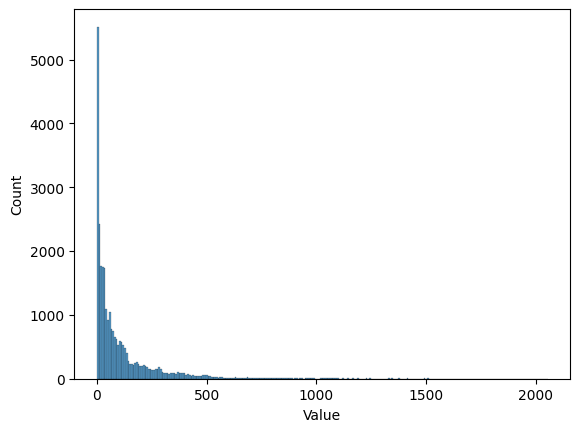

In [3]:
# Let's start cleaning the data. Let's check for duplicates
print(NG_wells_prod.duplicated().describe())
#There are no duplicates. There are also 0 non-null values.

#Let's check the Value column

sns.histplot(data=NG_wells_prod,x='Value')
plt.show()


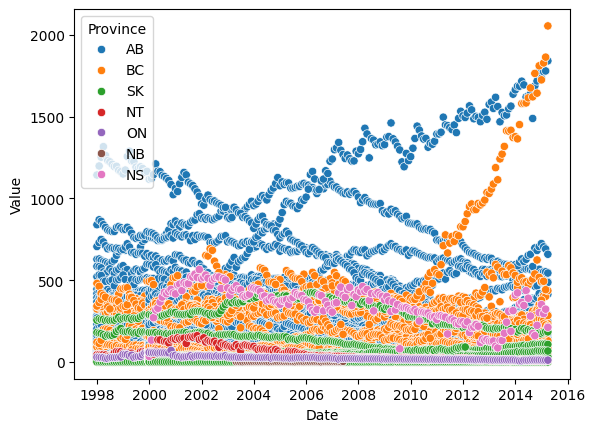

In [4]:
#The histogram looks left-skewed. We will invesrigate the data depending on the gas area

sns.scatterplot(data=NG_wells_prod,x='Date',y='Value',hue='Province')
plt.show()

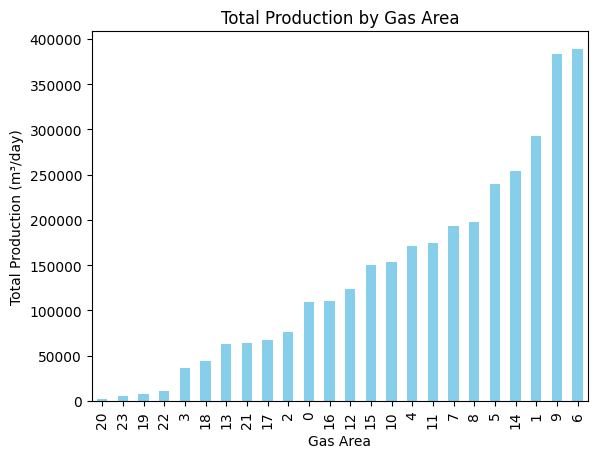

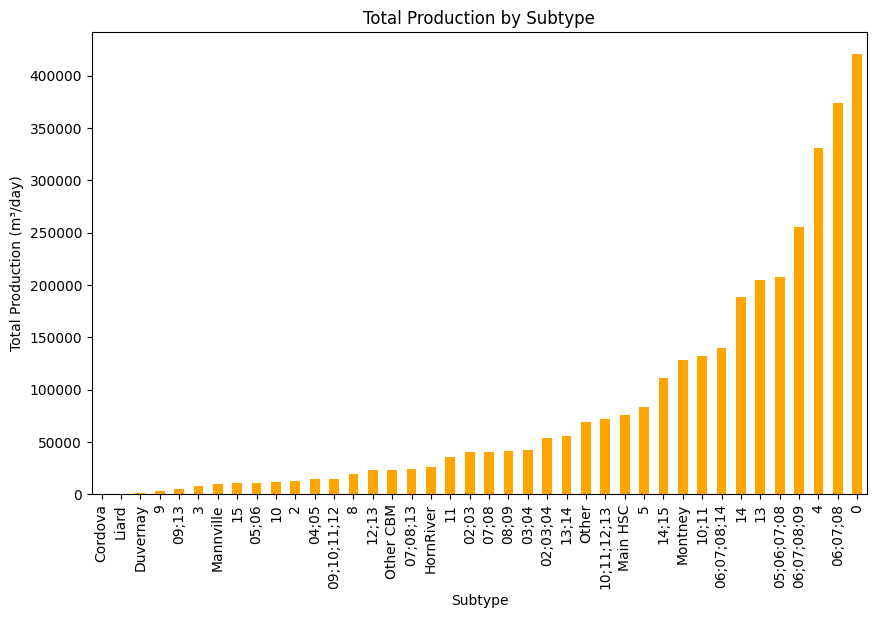

In [5]:
# Let's check the total production per area and subtype so see which areas are most valuable to consider

area_production = NG_wells_prod.groupby('Gas Area')['Value'].sum().sort_values()

area_production.plot(kind='bar', color='skyblue')
plt.title('Total Production by Gas Area')
plt.xlabel('Gas Area')
plt.ylabel('Total Production (m³/day)')
plt.show()

# Similarly, create a bar chart for subtypes
subtype_production = NG_wells_prod.groupby('Sub-Type')['Value'].sum().sort_values()
plt.figure(figsize=(10, 6))
subtype_production.plot(kind='bar', color='orange')
plt.title('Total Production by Subtype')
plt.xlabel('Subtype')
plt.ylabel('Total Production (m³/day)')
plt.show()

The most valuable areas seem to be 1, 6, 9, 14. There seems to be a Gas Area 0, which doesnt exist. those values will be dropped. The largest producing subtype seems to be 0 and manville. let's focus on those.

In [6]:
NG_wells_prod=NG_wells_prod[NG_wells_prod['Gas Area']!=0]
print(NG_wells_prod.info())

<class 'pandas.core.frame.DataFrame'>
Index: 28428 entries, 72 to 29051
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Province  28428 non-null  object        
 1   Gas Area  28428 non-null  int64         
 2   Type      28428 non-null  object        
 3   Sub-Type  28428 non-null  object        
 4   Date      28428 non-null  datetime64[ns]
 5   Value     28428 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.5+ MB
None


Let's now evaluate per province

In [7]:
# It's messy. Let's split the data into Provinces
NG_wells_prod_AB=NG_wells_prod[NG_wells_prod['Province']=='AB']
NG_wells_prod_BC=NG_wells_prod[NG_wells_prod['Province']=='BC']
NG_wells_prod_SK=NG_wells_prod[NG_wells_prod['Province']=='SK']
NG_wells_prod_MB=NG_wells_prod[NG_wells_prod['Province']=='MB']
NG_wells_prod_ON=NG_wells_prod[NG_wells_prod['Province']=='ON']
NG_wells_prod_QU=NG_wells_prod[NG_wells_prod['Province']=='QU']
NG_wells_prod_NS=NG_wells_prod[NG_wells_prod['Province']=='NS']
NG_wells_prod_NF=NG_wells_prod[NG_wells_prod['Province']=='NF']
NG_wells_prod_NWT=NG_wells_prod[NG_wells_prod['Province']=='NWT']
NG_wells_prod_YK=NG_wells_prod[NG_wells_prod['Province']=='YK']
NG_wells_prod_NU=NG_wells_prod[NG_wells_prod['Province']=='NU']
NG_wells_prod_NT=NG_wells_prod[NG_wells_prod['Province']=='NT']


In [8]:
# Lets check the individual data
print(NG_wells_prod_AB.info())
print(NG_wells_prod_BC.info())
print(NG_wells_prod_SK.info())
print(NG_wells_prod_MB.info()) #empty
print(NG_wells_prod_ON.info())
print(NG_wells_prod_QU.info()) #empty
print(NG_wells_prod_NS.info())
print(NG_wells_prod_NF.info()) #empty
print(NG_wells_prod_NWT.info()) #empty
print(NG_wells_prod_YK.info()) #empty
print(NG_wells_prod_NU.info()) #empty
print(NG_wells_prod_NT.info())

<class 'pandas.core.frame.DataFrame'>
Index: 20596 entries, 72 to 21975
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Province  20596 non-null  object        
 1   Gas Area  20596 non-null  int64         
 2   Type      20596 non-null  object        
 3   Sub-Type  20596 non-null  object        
 4   Date      20596 non-null  datetime64[ns]
 5   Value     20596 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 5216 entries, 2376 to 26699
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Province  5216 non-null   object        
 1   Gas Area  5216 non-null   int64         
 2   Type      5216 non-null   object        
 3   Sub-Type  5216 non-null   object        
 4   Date      5216 non-null   datetime64[ns]
 5   Value     

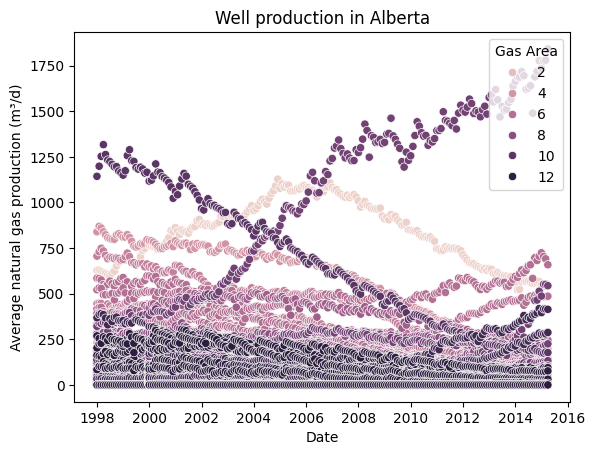

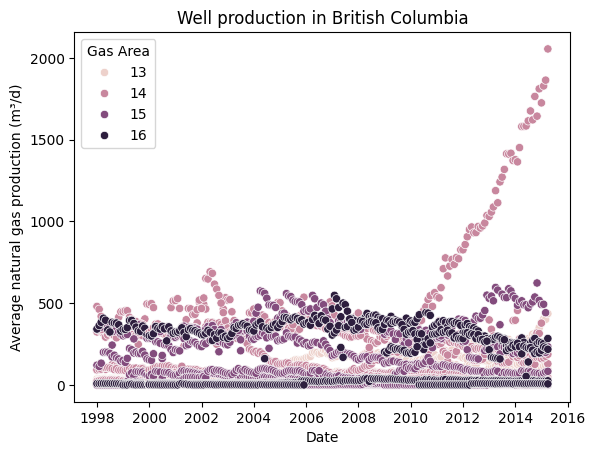

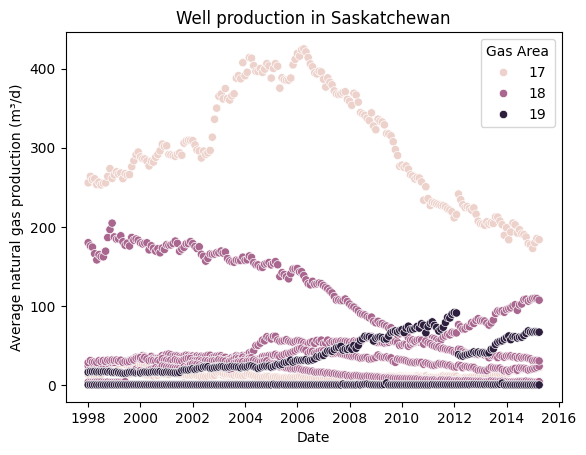

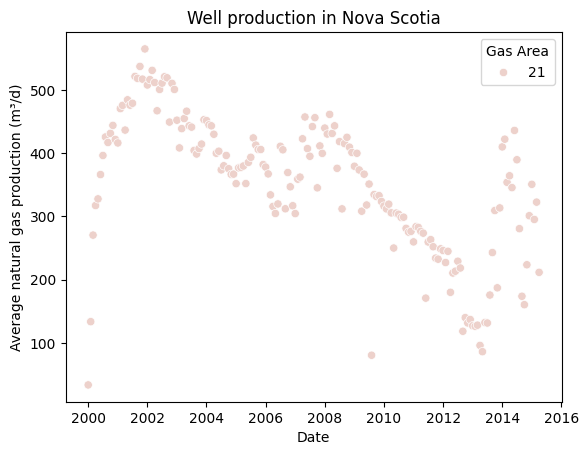

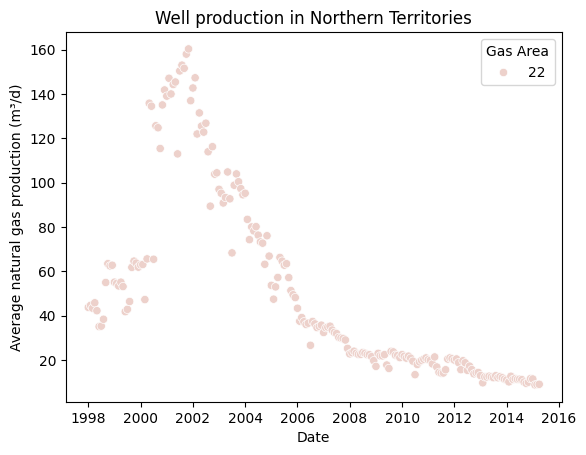

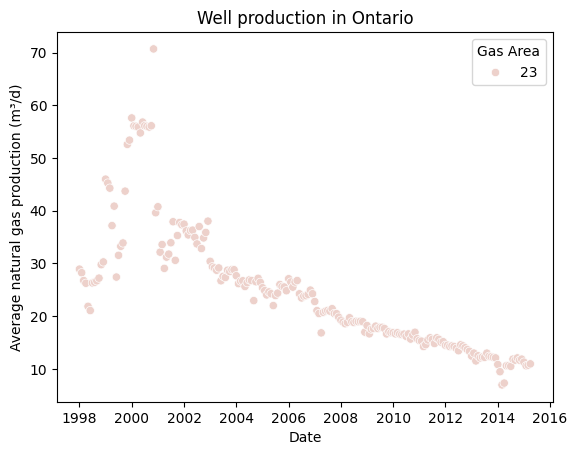

In [9]:
# We now know that there is no natural gas production in Manitoba, Quebec and New Foundland. Let's now look at the indivitual regions

sns.scatterplot(data=NG_wells_prod_AB,x='Date',y='Value',hue='Gas Area')
plt.title('Well production in Alberta')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_BC,x='Date',y='Value',hue='Gas Area')
plt.title('Well production in British Columbia')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_SK,x='Date',y='Value',hue='Gas Area')
plt.title('Well production in Saskatchewan')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_NS,x='Date',y='Value',hue='Gas Area')
plt.title('Well production in Nova Scotia')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_NT,x='Date',y='Value',hue='Gas Area')
plt.title('Well production in Northern Territories')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_ON,x='Date',y='Value',hue='Gas Area')
plt.title('Well production in Ontario')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

From these scatterplots we can confirm the following:


*   Natural gas production in Northern Territories and Ontario have been on a downward trend since 2002.
*   Natural gas production in Nova Scotia has been on a downward trend until 2013, ever since there has been an erratical upward trend
*   Alberta and British Columbia have most of the biggest reserves of natural gas and the largest production wells over Canada. These need more exploration.



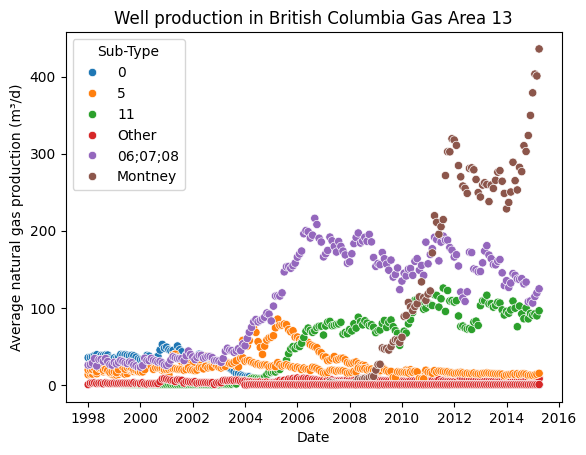

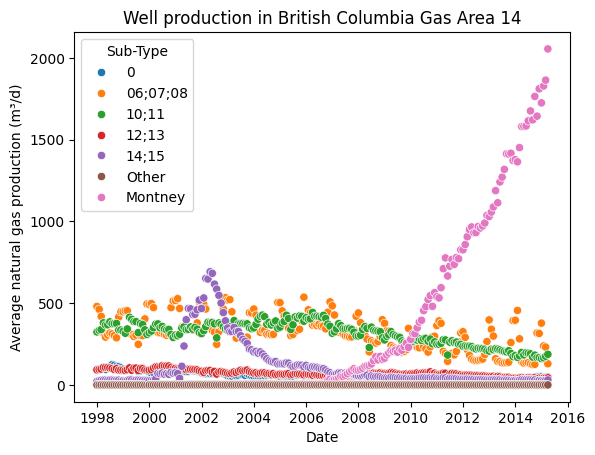

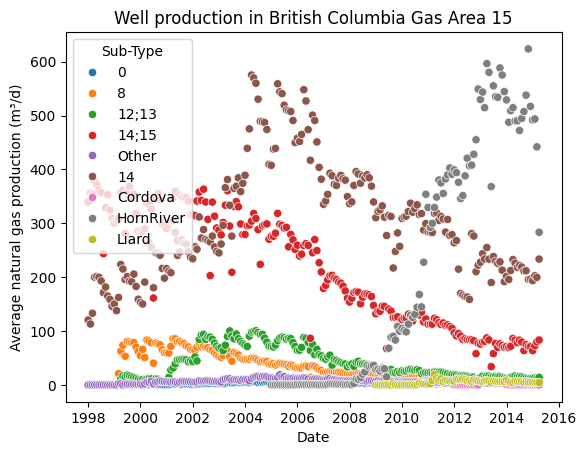

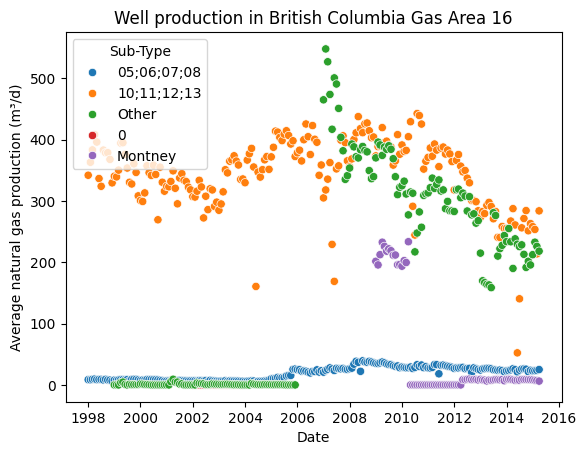

In [10]:
#British Columbia Analysis
sns.scatterplot(data=NG_wells_prod_BC[NG_wells_prod_BC['Gas Area']==13],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in British Columbia Gas Area 13')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_BC[NG_wells_prod_BC['Gas Area']==14],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in British Columbia Gas Area 14')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_BC[NG_wells_prod_BC['Gas Area']==15],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in British Columbia Gas Area 15')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_BC[NG_wells_prod_BC['Gas Area']==16],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in British Columbia Gas Area 16')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

From these scatterplots we can confirm the following:


*   Gas Area 14, more specifically the Montney subtype, has the highest amount of production from all British Columbia, with a very clear upward trend. It can similarly be seen in gas area 13.
*   The other areas of interest would be the gas areas that have an increasing production trend, with over 200 m3/d. These include: Manville in area 13 and 14 and Triasic in areas 13 and 14
*   The other areas seem to be producing a lot less than these significant areas.

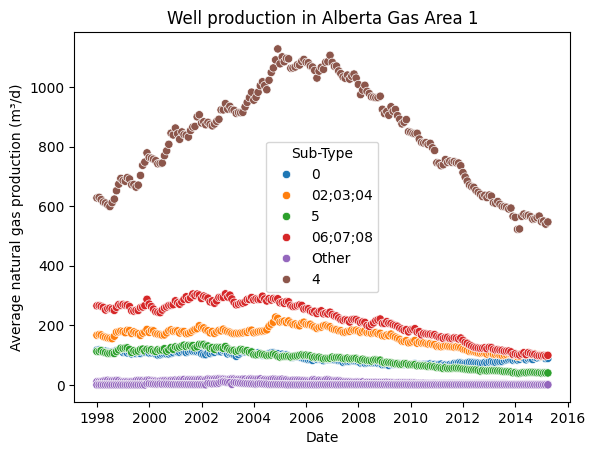

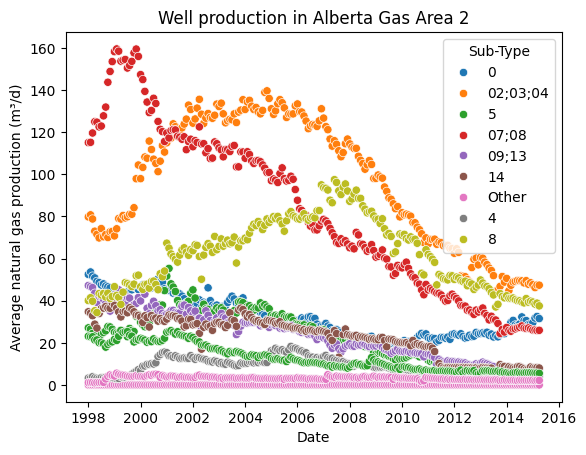

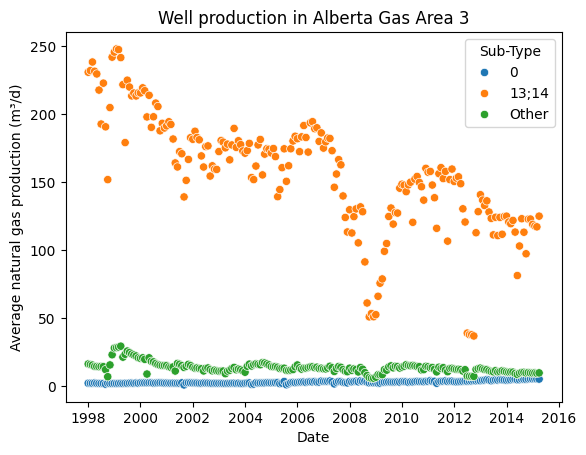

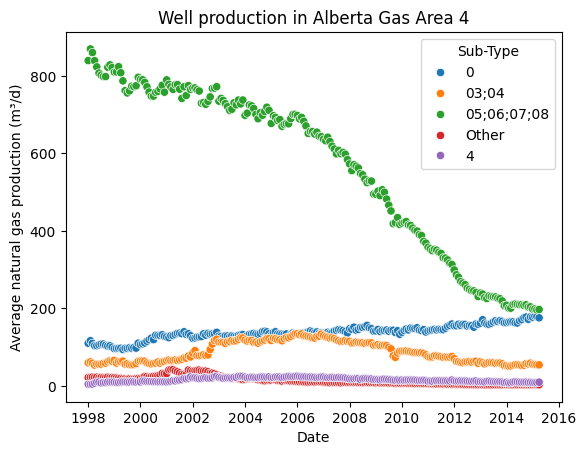

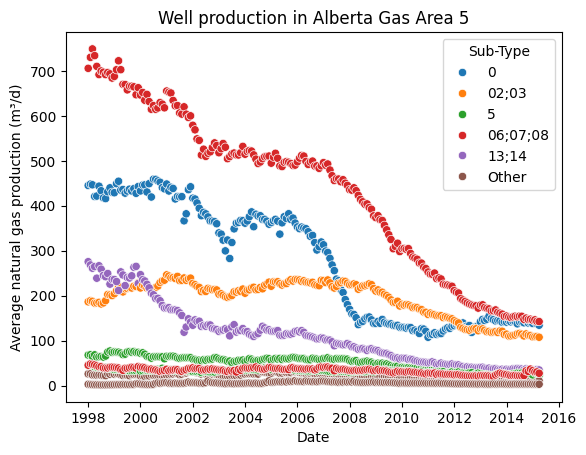

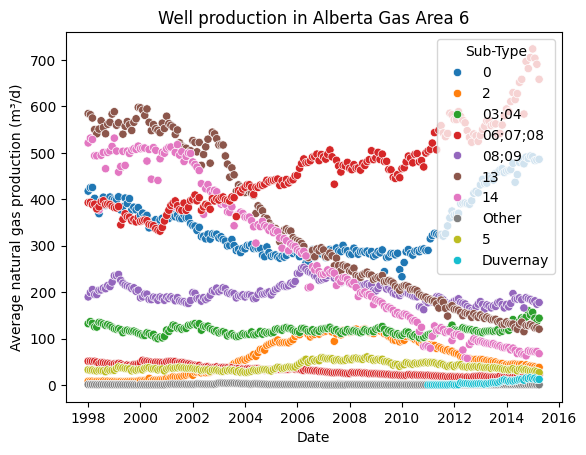

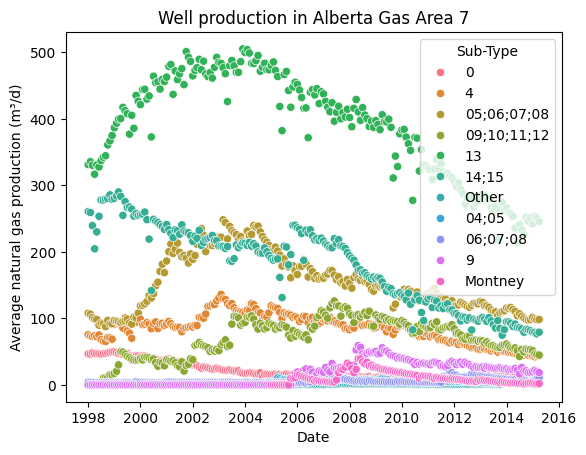

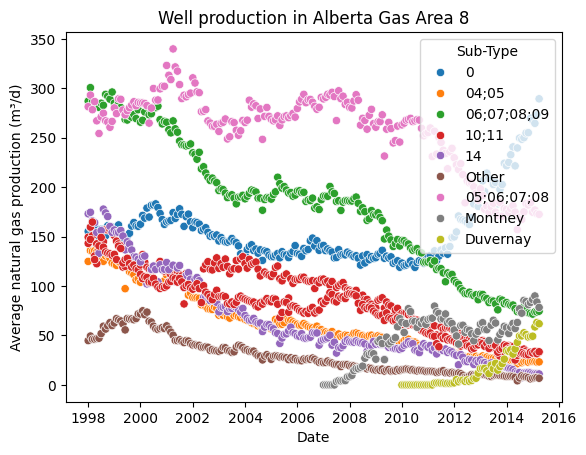

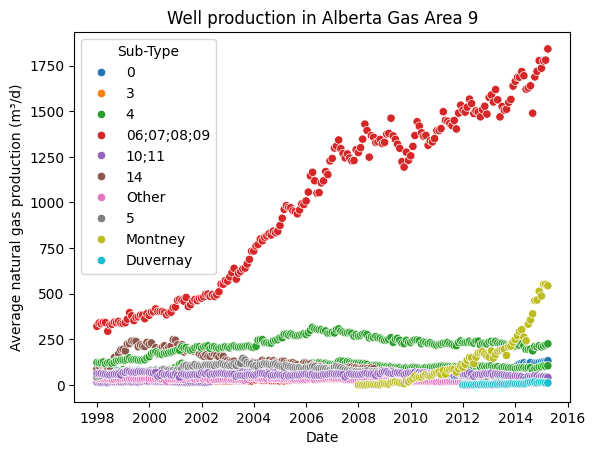

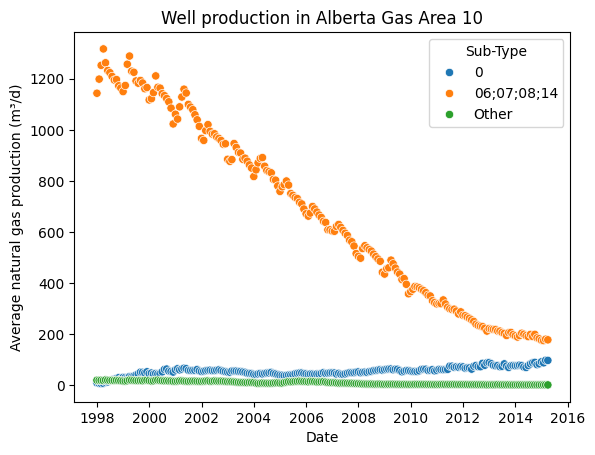

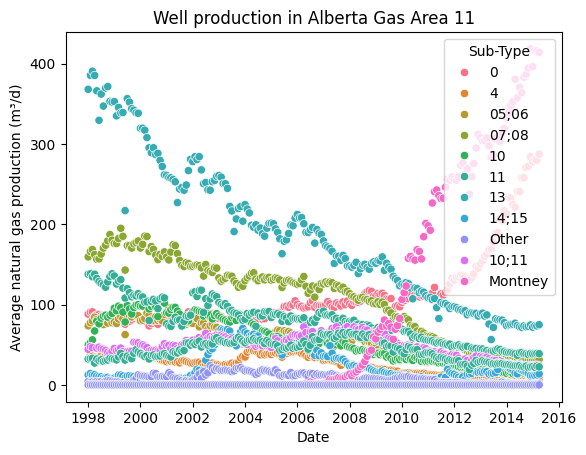

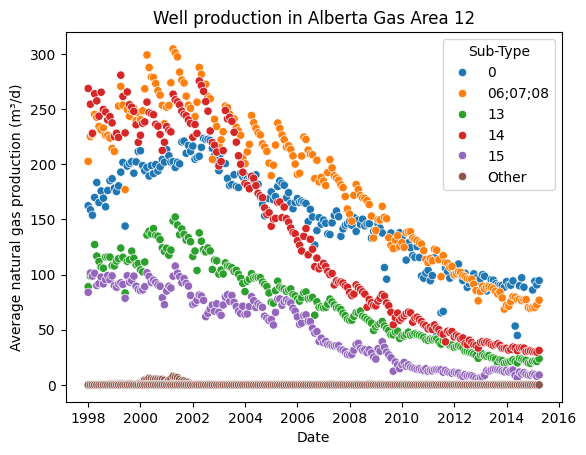

In [11]:
#British Columbia Analysis
sns.scatterplot(data=NG_wells_prod_AB[NG_wells_prod_AB['Gas Area']==1],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in Alberta Gas Area 1')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_AB[NG_wells_prod_AB['Gas Area']==2],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in Alberta Gas Area 2')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_AB[NG_wells_prod_AB['Gas Area']==3],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in Alberta Gas Area 3')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_AB[NG_wells_prod_AB['Gas Area']==4],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in Alberta Gas Area 4')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()
sns.scatterplot(data=NG_wells_prod_AB[NG_wells_prod_AB['Gas Area']==5],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in Alberta Gas Area 5')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_AB[NG_wells_prod_AB['Gas Area']==6],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in Alberta Gas Area 6')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_AB[NG_wells_prod_AB['Gas Area']==7],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in Alberta Gas Area 7')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_AB[NG_wells_prod_AB['Gas Area']==8],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in Alberta Gas Area 8')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()
sns.scatterplot(data=NG_wells_prod_AB[NG_wells_prod_AB['Gas Area']==9],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in Alberta Gas Area 9')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()
sns.scatterplot(data=NG_wells_prod_AB[NG_wells_prod_AB['Gas Area']==10],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in Alberta Gas Area 10')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_AB[NG_wells_prod_AB['Gas Area']==11],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in Alberta Gas Area 11')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

sns.scatterplot(data=NG_wells_prod_AB[NG_wells_prod_AB['Gas Area']==12],x='Date',y='Value',hue='Sub-Type')
plt.title('Well production in Alberta Gas Area 12')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()


The highlights of the previous histograms are:

*  Gas Area 9 shows the Largest production from all Alberta, specifically from Manville and Colorado subtypes, with an increasing trend.
*   In general, sub types 0, Montney and Duvernay have shown an increasing trend in most of the areas
*   Areas 1 2 3 7 12 do not show a worthwile production to analyse. Areas 4 5  10 only show type 0 production increase. The rest of the areas show an increasing trend over 200 m3/d in multple subtypes.



Let's Summarize the areas of interest:

*   Gas Area 6: Subtypes 06;07;08 and 0
*   Gas Area 8: Subtypes 0 Montney and Duverney
*   Gas Area 9: Subtype 06;07;08;09, Montney
*   Gas Area 11: Subtypes 0 and Montney
*   Subtype 0: Gas Areas 4 5 6 8 9 10 11
*   Gas Area 13: Subtypes 11 and Montney
*   Gas Area 14: Subtypes 06;07;08 10;11 and Montney
*   Gas Area 15: Subtype Horndriver

We will now proceed with forecasting

In [12]:
#Adding date and year to data
NG_wells_prod['Year'] = NG_wells_prod['Date'].dt.year
NG_wells_prod['Month'] = NG_wells_prod['Date'].dt.month

In [13]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [86]:
#Splitting the data into desirable dataset
Gas_4=NG_wells_prod[NG_wells_prod['Gas Area']==4]
Gas_4_0=Gas_4[Gas_4['Sub-Type']=='0']
Gas_4_0 = Gas_4_0.dropna()
Gas_5=NG_wells_prod[NG_wells_prod['Gas Area']==5]
Gas_5_0=Gas_5[Gas_5['Sub-Type']=='0']
Gas_5_0 = Gas_5_0.dropna()
Gas_6=NG_wells_prod[NG_wells_prod['Gas Area']==6]
Gas_6_Manville=Gas_6[Gas_6['Sub-Type']=='06;07;08']
Gas_6_Manville = Gas_6_Manville.dropna()
Gas_6_0=Gas_6[Gas_6['Sub-Type']=='0']
Gas_6_0 = Gas_6_0.dropna()
Gas_8=NG_wells_prod[NG_wells_prod['Gas Area']==8]
Gas_8_0=Gas_8[Gas_8['Sub-Type']=='0']
Gas_8_0 = Gas_8_0.dropna()
Gas_8_Montney=Gas_8[Gas_8['Sub-Type']=='Montney']
Gas_8_Montney=Gas_8_Montney.dropna()
Gas_8_Duvernay=Gas_8[Gas_8['Sub-Type']=='Duvernay']
Gas_8_Duvernay=Gas_8_Duvernay.dropna()
Gas_9=NG_wells_prod[NG_wells_prod['Gas Area']==9]
Gas_9_Manville=Gas_9[Gas_9['Sub-Type']=='06;07;08;09']
Gas_9_Manville=Gas_9_Manville.dropna()
Gas_9_Montney=Gas_9[Gas_9['Sub-Type']=='Montney']
Gas_9_Montney=Gas_9_Montney.dropna()
Gas_9_0=Gas_9[Gas_9['Sub-Type']=='0']
Gas_9_0=Gas_9_0.dropna()
Gas_10=NG_wells_prod[NG_wells_prod['Gas Area']==10]
Gas_10_0=Gas_10[Gas_10['Sub-Type']=='0']
Gas_10_0=Gas_10_0.dropna()
Gas_11=NG_wells_prod[NG_wells_prod['Gas Area']==11]
Gas_11_0=Gas_11[Gas_11['Sub-Type']=='0']
Gas_11_0=Gas_11_0.dropna()
Gas_11_Montney=Gas_11[Gas_11['Sub-Type']=='Montney']
Gas_11_Montney=Gas_11_Montney.dropna()
Gas_13=NG_wells_prod[NG_wells_prod['Gas Area']==13]
Gas_13_11=Gas_13[Gas_13['Sub-Type']=='11']
Gas_13_11=Gas_13_11.dropna()
Gas_13_Montney=Gas_13[Gas_13['Sub-Type']=='Montney']
Gas_13_Montney=Gas_13_Montney.dropna()
Gas_14=NG_wells_prod[NG_wells_prod['Gas Area']==14]
Gas_14_Manville=Gas_14[Gas_14['Sub-Type']=='06;07;08']
Gas_14_Manville=Gas_14_Manville.dropna()
Gas_14_Triasic=Gas_14[Gas_14['Sub-Type']=='10;11']
Gas_14_Triasic=Gas_14_Triasic.dropna()
Gas_14_Montney=Gas_14[Gas_14['Sub-Type']=='Montney']
Gas_14_Montney=Gas_14_Montney.dropna()
Gas_15=NG_wells_prod[NG_wells_prod['Gas Area']==15]
Gas_15_HornRiver=Gas_15[Gas_15['Sub-Type']=='HornRiver']
Gas_15_HornRiver=Gas_15_HornRiver.dropna()

In [15]:
print(Gas_4_0.head())

    Province  Gas Area Type Sub-Type       Date       Value  Year  Month
576       AB         4    0        0 1998-01-01  110.245670  1998      1
577       AB         4    0        0 1998-02-01  116.729683  1998      2
578       AB         4    0        0 1998-03-01  109.836092  1998      3
579       AB         4    0        0 1998-04-01  104.016298  1998      4
580       AB         4    0        0 1998-05-01  103.879726  1998      5


In [46]:
def forecasting(Data,gas_area,subtype):
    x1=Data[['Month','Year']]
    y1=Data['Value']
    train_size = int(0.8 * len(Data))
    X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42)
    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse=mean_squared_error(y_test, y_pred)
    print(np.sqrt(mse))
    display_scores(np.sqrt(-scores))
    future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')
    future_data = pd.DataFrame({'Date': future_dates})
    future_data['Month'] = future_data['Date'].dt.month
    future_data['Year'] = future_data['Date'].dt.year
    future_predictions = model.predict(future_data.drop(columns=['Date']))
    future_data['Value'] = future_predictions
    sns.scatterplot(data=future_data,x='Date',y='Value')
    sns.scatterplot(data=Data,x='Date',y='Value')
    plt.title(f"Production Prediction in Gas Area {gas_area}, Subtype {subtype}")
    plt.show()

4.433932647998315
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


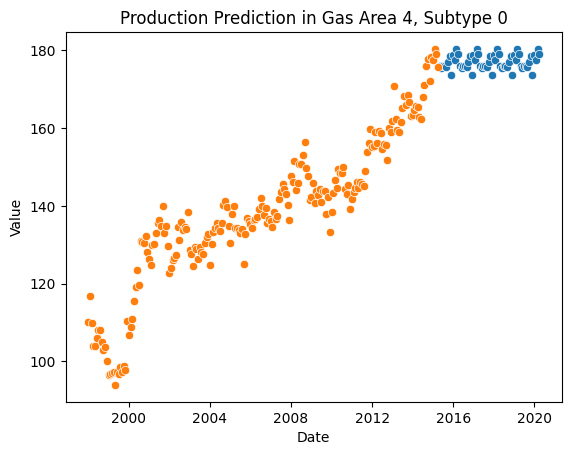

In [48]:
# Forcasting of Gas area 4 subtype 0
forecasting(Gas_4_0,4,0)

16.309769610442494
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


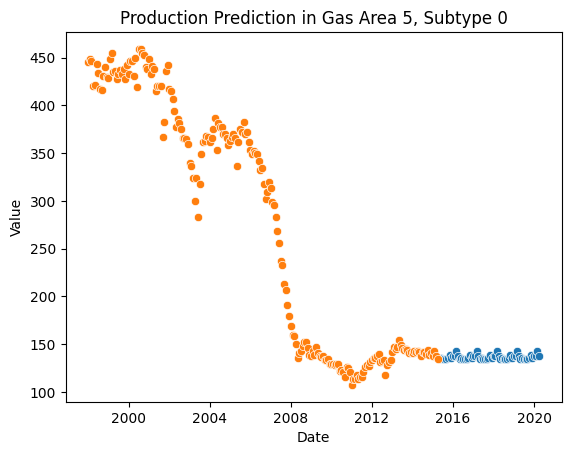

In [49]:
# Forcasting of Gas area 5 subtype 0
forecasting(Gas_5_0,5,0)

15.222200361547527
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


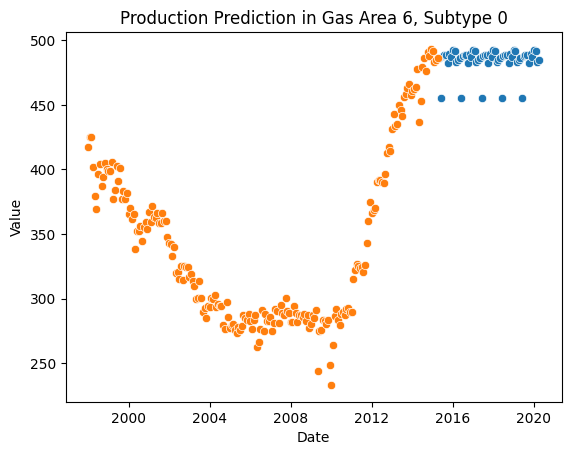

In [50]:
# Forcasting of Gas area 6 subtype 0
forecasting(Gas_6_0,6,0)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:45:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:45:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:45:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:45:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


432.75229685837354
Scores: [269.18683865 425.61094808 504.04746674 403.63943173 527.14974215]
Mean: 425.927
Std: 91.009


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:45:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:45:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
<ipython-input-19-90f0d8d264f8>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Gas_6_Manville['Date'].max(), periods=60, freq='M')


Text(0.5, 1.0, 'Well production Prediction in Gas Area 6 Subtype 0')

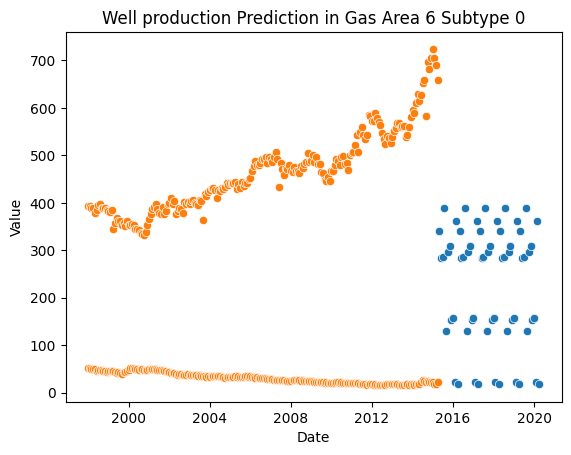

In [19]:
# Forcasting of Gas area 6 subtype Manville
forecasting(Gas_6_Manville,6,'Manville')

This prediction is not accurate. It seems that the Manville subtype is subdivided. We should explore it closely

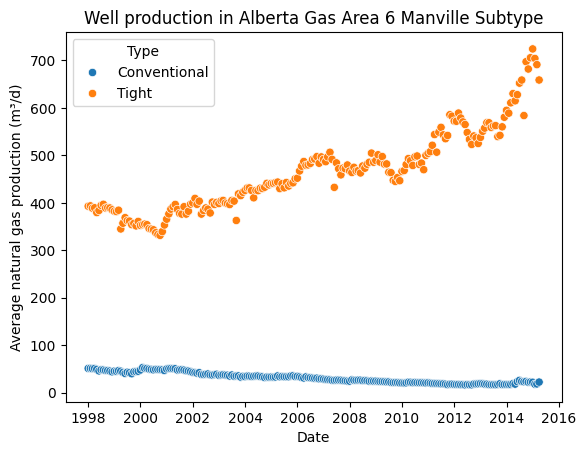

In [57]:
sns.scatterplot(data=Gas_6_Manville,x='Date',y='Value',hue='Type')
plt.title('Well production in Alberta Gas Area 6 Manville Subtype')
plt.ylabel('Average natural gas production (m³/d)')
plt.show()

19.24522589790096
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


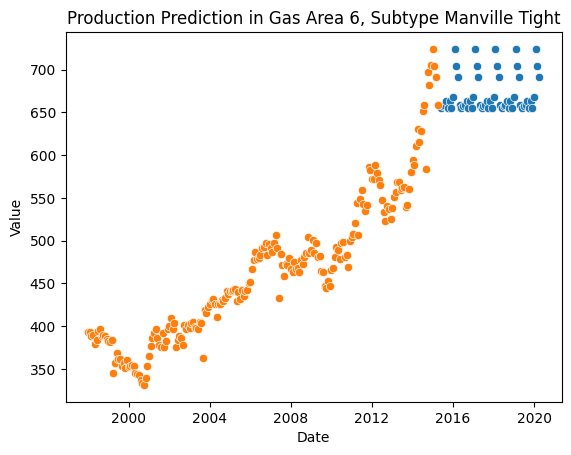

In [68]:
#We are interested in the tight Type.
Gas_6_Manville_Tight=Gas_6_Manville[Gas_6_Manville['Type']=='Tight']
Gas_6_Manville_Tight = Gas_6_Manville_Tight.dropna()

forecasting(Gas_6_Manville_Tight,6,'Manville Tight')

6.462695364859292
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


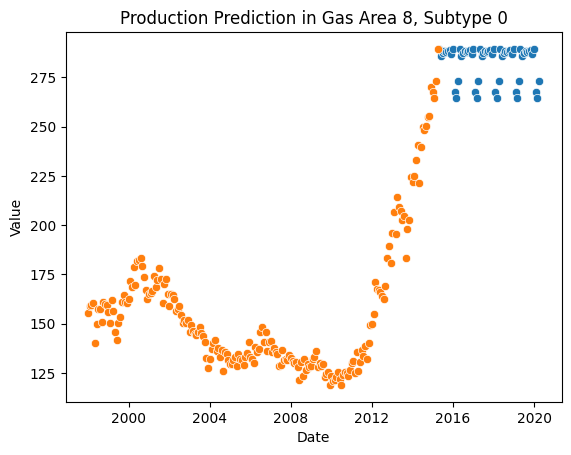

In [52]:
# Forcasting of Gas area 8 subtype 0
forecasting(Gas_8_0,8,0)

5.519239758785465
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


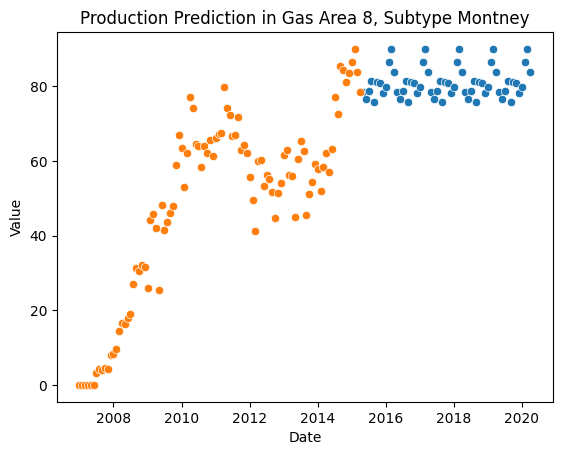

In [54]:
# Forcasting of Gas area 8 subtype Montney
forecasting(Gas_8_Montney,8,'Montney')

3.347135477161811
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


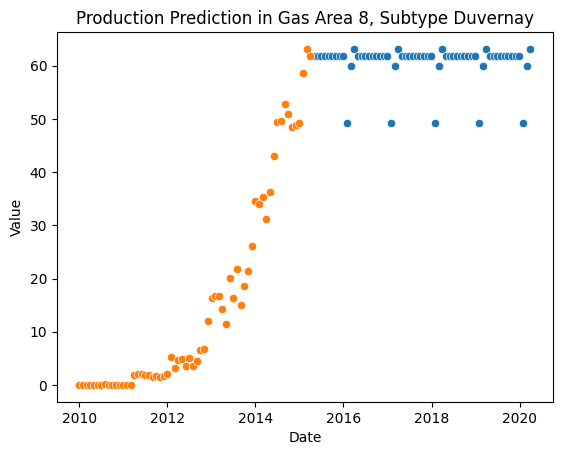

In [65]:
# Forcasting of Gas area 8 subtype Duvernay
forecasting(Gas_8_Duvernay,8,'Duvernay')

40.6617428559871
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


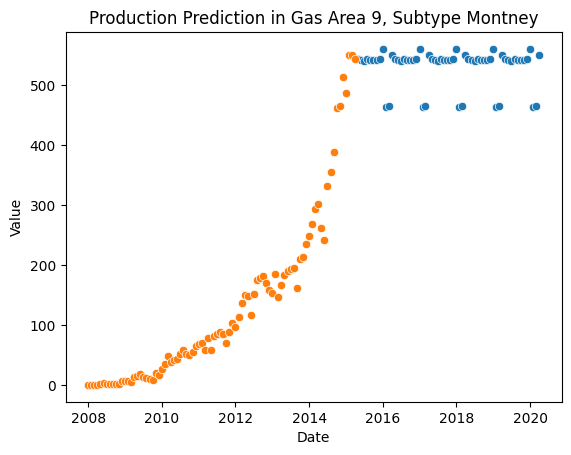

In [66]:
# Forcasting of Gas area 9 subtype Montney
forecasting(Gas_9_Montney,9,'Montney')

40.90559236074546
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


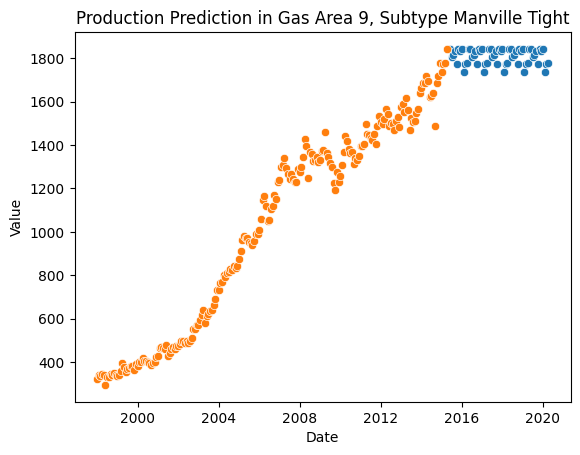

In [70]:
# Forecasting of Gas area 9 subtype Manville Tight
Gas_9_Manville_Tight=Gas_9_Manville[Gas_9_Manville['Type']=='Tight']
Gas_9_Manville_Tight = Gas_9_Manville_Tight.dropna()

forecasting(Gas_9_Manville_Tight,9,'Manville Tight')

3.4848460427498336
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


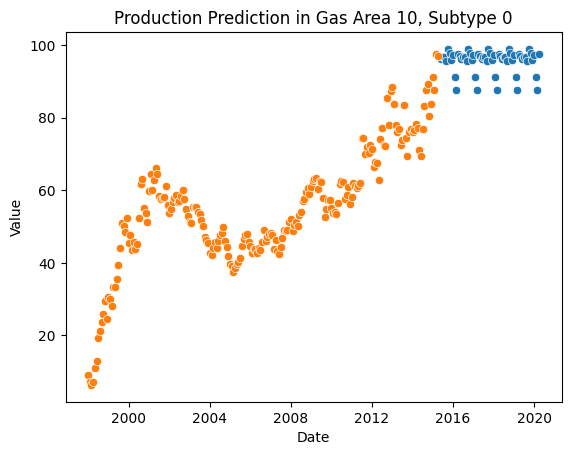

In [71]:
# Forecasting of Gas area 10 subtype 0
forecasting(Gas_10_0,10,0)

5.005759448091559
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


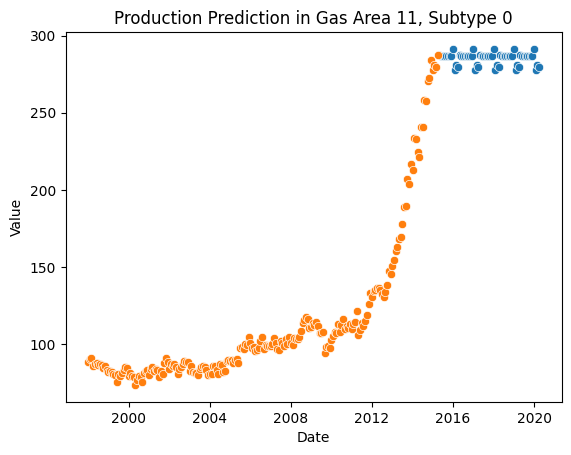

In [72]:
# Forecasting of Gas area 11 subtype 0
forecasting(Gas_11_0,11,0)

7.85228213193493
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


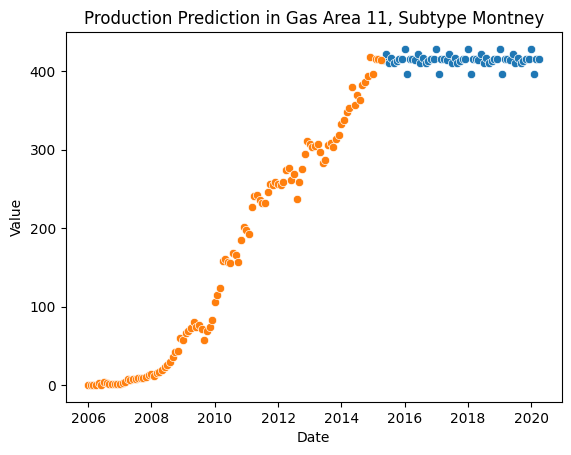

In [73]:
# Forecasting of Gas area 11 subtype montney
forecasting(Gas_11_Montney,11,'Montney')

5.808926980296663
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


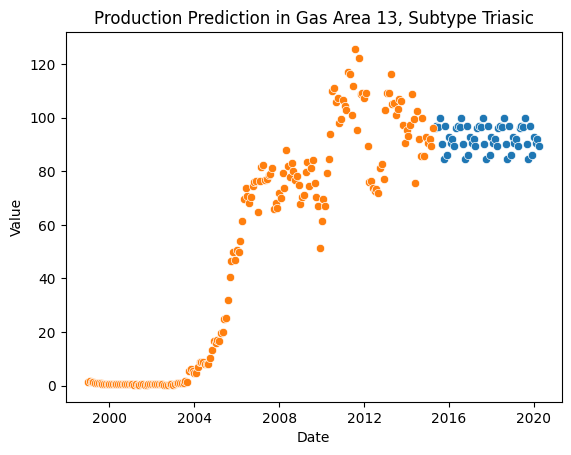

In [77]:
# Forecasting of Gas area 13 subtype triassic
forecasting(Gas_13_11,13,'Triasic')

11.819250505685588
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


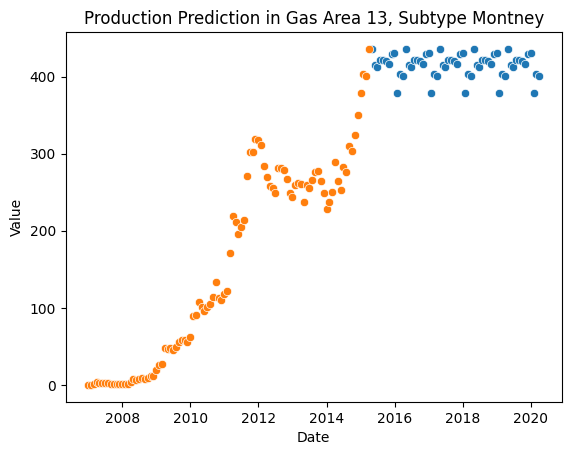

In [78]:
# Forecasting of Gas area 13 subtype Montney
forecasting(Gas_13_Montney,13,'Montney')

48.23403078172905
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


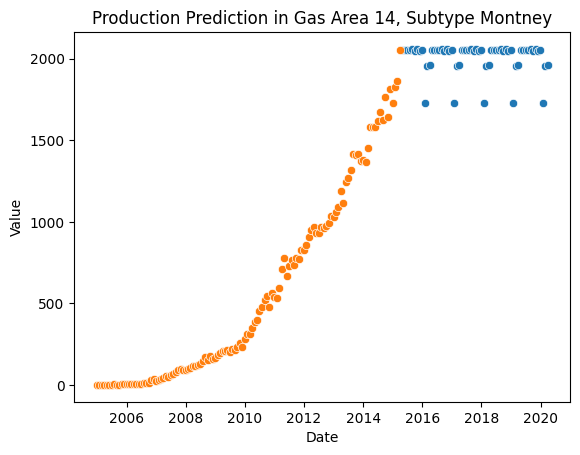

In [79]:
# Forecasting of Gas area 14 subtype Montney
forecasting(Gas_14_Montney,14,'Montney')

36.8441551387666
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


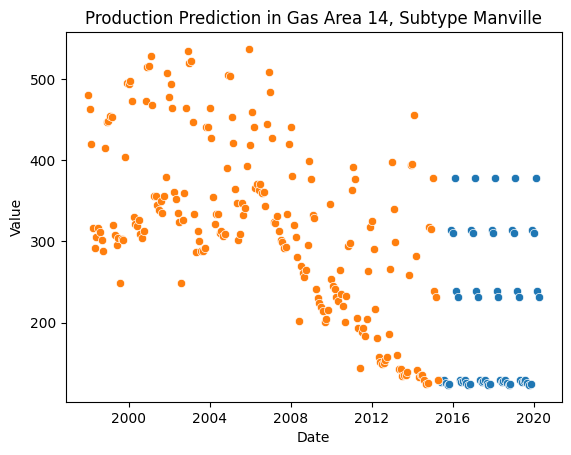

In [82]:
# Forecasting of Gas area 14 subtype Manville
forecasting(Gas_14_Manville,14,'Manville')

25.00999372550604
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


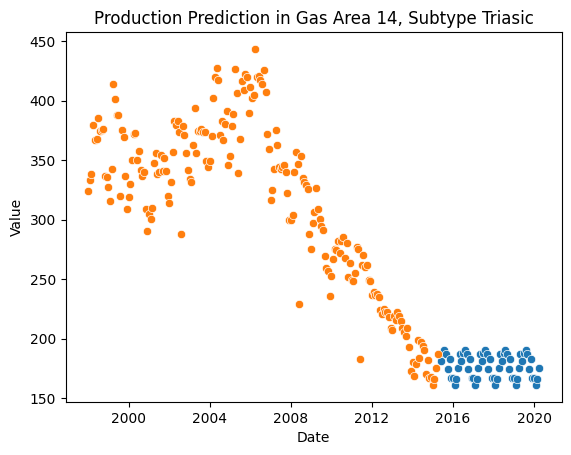

In [83]:
# Forecasting of Gas area 14 subtype triassic
forecasting(Gas_14_Triasic,14,'Triasic')

66.0366231827529
Scores: [14.88265198 17.9818465   6.30535491 14.68097792 86.64239507]
Mean: 28.099
Std: 29.527


<ipython-input-46-9d925ce12fe2>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=Data['Date'].max(), periods=60, freq='M')


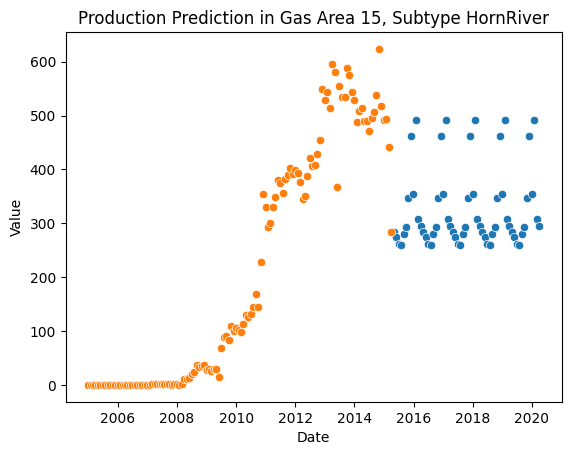

In [87]:
# Forecasting of Gas area 15 subtype Horndriver
forecasting(Gas_15_HornRiver,15,'HornRiver')

**Conclusions:**


1.   The best producing area from Alberta is Deep Basin - Manville Tight, with projections of over 1750 m3/d. It is recommended to keep increasing production in this sector
2.   The best producing area from British Columbia is Fort St John - Montney, with projections of over 2000 m3/d. It is recommended to keep increasing production in this sector
3.   Gas produced along with oil from oil wells in West Central, Kaybob and Peace River from Alberta has potential of future production of over 300 m3/d. The rest of the same type of gas does not meet the expectations. Since this particular type of extracted natural gas extracted is a partial product from oil wells, their oil production need to be evaluated before suggesting more actions regarding these wells.
4.   Gas produced from Montney and Duverney in Kaybob Alberta is very recent and there is not as much data, however, although it has potential of increasing production, the amount is very low, less than 100 m3/d. The amount of wells compared to other zones before suggesting further actions. However, gas produced from Manville in this area is recommended to be boosted since it has an increased production of over 700 m3/d for the next 5 years.
5.   Gas produced from Montney in Peace River Alberta and BC Deep Basin has potential of future production of over 400 m3/d. It is very recommended to increase more wells and production in those areas.
6.   Gas produced from Triasic in Deep basin and Northeast BC show a predicted decline, hence it is recommended to not focus on these wells for the foreseeable future.

